In [1]:
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import Normalize, ImagePair, calculate_overlap
import torchvision
from models.generator import GeneratorRRDB
from models.discriminator import Discriminator
from models.feature_extractor import FeatureExtractor

from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
import pytorch_lightning as pl

from torchvision.utils import save_image
from torchsummary import summary
import time
from utils import save_subject

print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
std = 0.3548


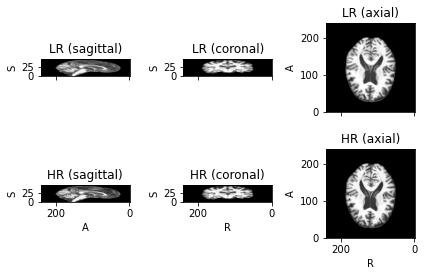

In [4]:
img_real = ImagePair(number=1, simulated=False, select_slices=48)
real_subject = [img_real.subject()]
real_set = tio.SubjectsDataset(
    real_subject, transform=Normalize(std=std))

real_set[0].plot()

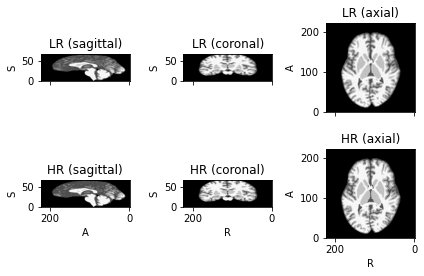

In [5]:
img_sim = ImagePair(number=100206, simulated=True, select_slices=70)
sim_subject = [img_sim.subject()]

sim_set = tio.SubjectsDataset(
    sim_subject, transform=Normalize(std=std))

sim_set[0].plot()

In [70]:
def fft2_plot(slice):
    return torch.log10(abs(torch.fft.fftshift(torch.fft.fft2(slice))))

def fft2_plot_diff(slice1, slice2):
    slice1_fft = torch.fft.fftshift(torch.fft.fft2(slice1))
    slice2_fft = torch.fft.fftshift(torch.fft.fft2(slice2))
    return torch.log10(abs(slice1_fft-slice2_fft))

def fft2_plot_masked(slice, mask):
    slice_fft = torch.fft.fftshift(torch.fft.fft2(slice))
    return torch.log10(abs(slice_fft))*mask

def freq_energy(slice, mask):
    slice_fft = torch.fft.fftshift(torch.fft.fft2(slice))
    masked_fft = slice_fft*mask
    energy = torch.sum(abs(torch.square(masked_fft)))
    return energy

def square_mask(slice, size):
    mask = torch.zeros_like(slice)
    if isinstance(size, int):
        mask[int(slice.shape[0]/2-size/2):int(slice.shape[0]/2+size/2),
             int(slice.shape[0]/2-size/2):int(slice.shape[0]/2+size/2)] = 1
    if isinstance(size, tuple):
        if size[1]<=size[0]:
            return 'outer size must be larger dan inner size'
        mask[int(slice.shape[0]/2-size[1]/2):int(slice.shape[0]/2+size[1]/2),
             int(slice.shape[0]/2-size[1]/2):int(slice.shape[0]/2+size[1]/2)] = 1
        mask[int(slice.shape[0]/2-size[0]/2):int(slice.shape[0]/2+size[0]/2),
             int(slice.shape[0]/2-size[0]/2):int(slice.shape[0]/2+size[0]/2)] = 0
    return mask

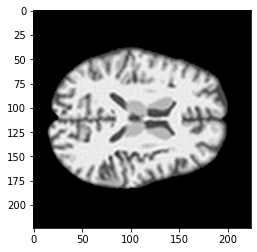

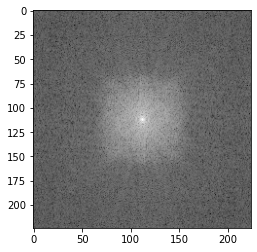

In [246]:
LR = img_sim.subject()['LR']
LR_slice = LR.data[0,:,:,40]

plt.figure()
plt.imshow(LR_slice, cmap='gray')
plt.figure()
plt.imshow(fft2_plot(LR_slice), cmap='gray')

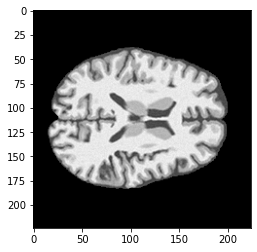

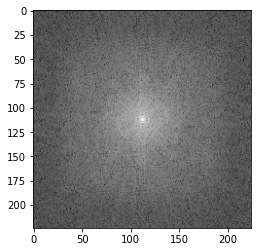

In [247]:
HR = img_sim.subject()['HR']
HR_slice = HR.data[0,:,:,40]

plt.figure()
plt.imshow(HR_slice, cmap='gray')
plt.figure()
plt.imshow(fft2_plot(HR_slice), cmap='gray')

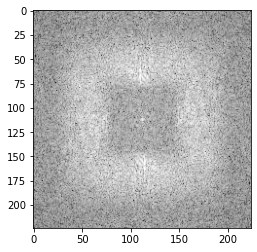

In [248]:
plt.imshow(fft2_plot_diff(LR_slice, HR_slice), cmap='gray')

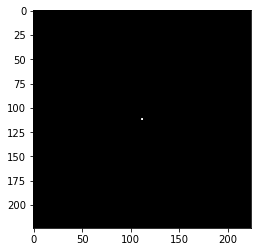

In [249]:
plt.imshow(fft2_plot_masked(LR_slice, square_mask(LR_slice, 2)), cmap='gray')

LR energy:  116766264.48205037
HR energy:  116435605.98854712
Diff energy:  -330658.49350325763


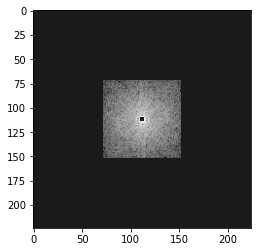

In [255]:
size = (4,80)
# size = (80,224)

plt.imshow(fft2_plot_masked(LR_slice, square_mask(LR_slice, size)), cmap='gray')

LR_energy = freq_energy(LR_slice, square_mask(LR_slice, size))
HR_energy = freq_energy(HR_slice, square_mask(LR_slice, size))

print('LR energy: ', LR_energy.numpy())
print('HR energy: ', HR_energy.numpy())
print('Diff energy: ', (HR_energy - LR_energy).numpy())

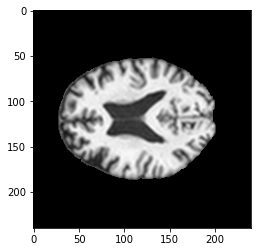

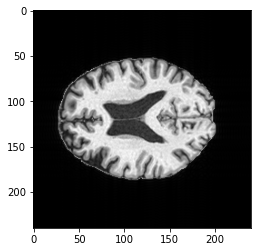

In [240]:
LR_fft = torch.fft.fftshift(torch.fft.fft2(LR_slice))
HR_fft = torch.fft.fftshift(torch.fft.fft2(HR_slice))
HR_fft_masked = HR_fft*square_mask(HR_slice, (80,240))
LR_fft_added = LR_fft + HR_fft_masked
LR_ifft_added = torch.fft.ifft2(torch.fft.ifftshift(LR_fft_added))
HR_ifft = torch.fft.ifft2(torch.fft.ifftshift(HR_fft_masked))
# plt.imshow(abs(HR_ifft)+.5, vmin=0, vmax=1, cmap='gray')
# plt.imshow(LR_slice-abs(HR_ifft), cmap='gray')
plt.figure()
plt.imshow(abs(LR_slice), cmap='gray')
plt.figure()
plt.imshow(abs(LR_ifft_added), cmap='gray')

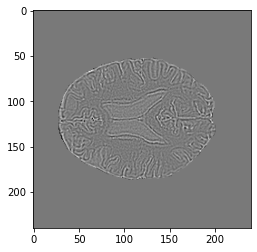

In [171]:
plt.imshow(LR_slice-HR_slice, cmap='gray')

39326.0
0.6827430555555556


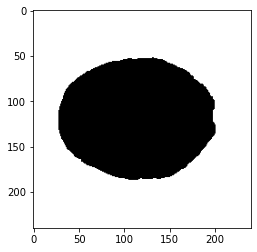

In [203]:
mask = np.zeros_like(LR_slice.numpy())
mask[np.where(LR_slice.numpy() < 1e-2)] = 1
plt.imshow(mask, cmap='gray')
print(np.sum(mask))
print(np.sum(mask)/(240*240))